# Analyse Spatial Patterns in Classifications

In [99]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
import seaborn as sns
import contextily as ctx
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy.stats import entropy

In [100]:
city='sanfrancisco'

### Get gentrification scores, convert to geodataframe

In [164]:
base_dir = os.path.expanduser(f"../../../data/AirbnbData/airbnb-{city}/")
gentrification_df = pd.read_csv(base_dir + 'airbnb_gentrification_scores_categorical_combined_listings_filtered_01.csv')
gentrification_df['geometry'] = gentrification_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gentrification_gdf = gpd.GeoDataFrame(gentrification_df, geometry='geometry', crs="EPSG:4326")
mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
gentrification_gdf['gentrification_prediction_code'] = gentrification_gdf['gentrification_prediction'].map(mapping)

### Get spatial data + gentrification index data

In [237]:
census_tracts =  gpd.read_file('../../../data/SpatialData/SanFran/Census_2020_Tracts_SanFran/Census_Tracts_SanFran_2020.shp')
census_tracts = census_tracts.sort_values(by='tractce')
census_tracts = census_tracts[census_tracts['tractce']!='980401']
census_tracts = census_tracts[['geometry', 'geoid']]

243


### Plot listings with census tracts

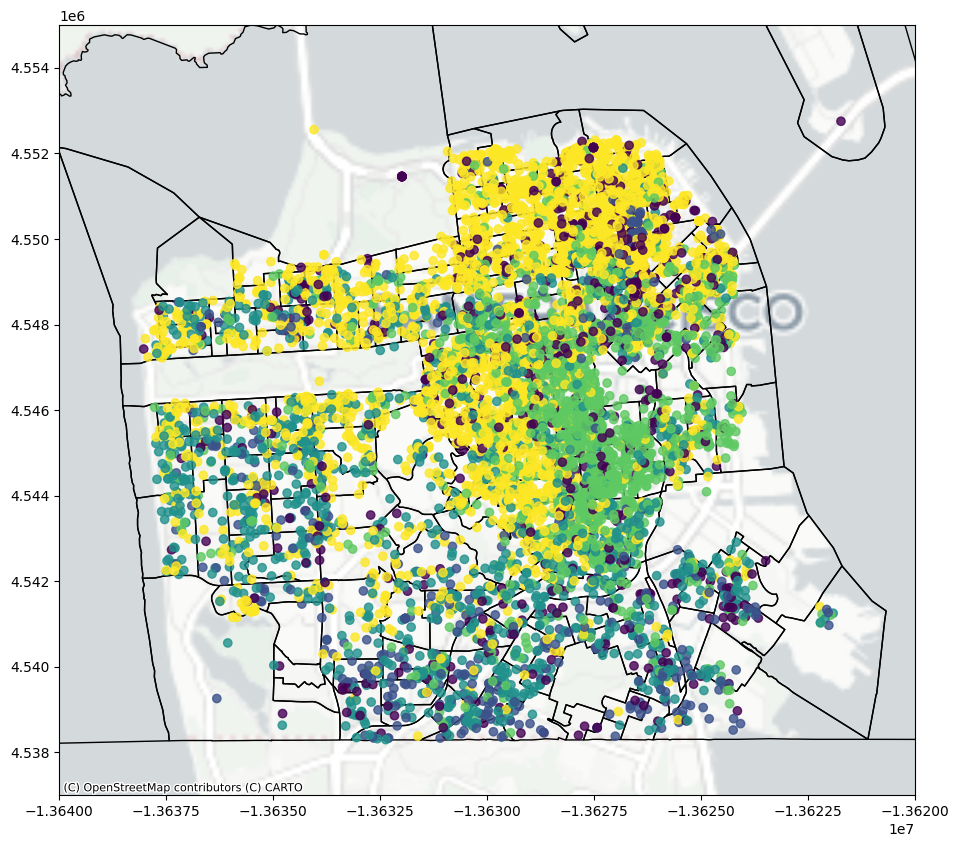

In [236]:
fig,ax=plt.subplots(figsize=(15,10))
census_tracts = census_tracts.to_crs(epsg=3857)
gentrification_gdf_wm = gentrification_gdf.to_crs(epsg=3857)
census_tracts.plot(ax=ax, edgecolor = 'black', facecolor='none'), 
gentrification_gdf_wm.plot("gentrification_prediction_code", alpha=0.8, ax=ax)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=suburb_proportions_gdf.crs)
ax.set_xlim(-13640000, -13620000)
ax.set_ylim(4537000, 4555000);

### Get summary score (mode) for each suburb

In [221]:
gentrification_gdf = gentrification_gdf[['latitude', 'longitude', 'geometry', 'gentrification_prediction', 'gentrification_prediction_code', 'explanation']]
# Step 1: Spatial join - assign each listing to its polygon
listings_with_geoid = gpd.sjoin(gentrification_gdf, census_tracts[['geoid', 'geometry']], how='inner', predicate='within')

In [178]:
suburb_counts = listings_with_geoid.groupby("geoid")["gentrification_prediction_code"].count()
suburb_counts_df = pd.DataFrame({'count': suburb_counts})
suburb_counts_df.reset_index(inplace=True)
suburb_counts_df = census_tracts[['geoid', 'geometry']].merge(suburb_counts_df, on='geoid')
## Should we require a minimum number of listings?
suburb_counts_df = suburb_counts_df[suburb_counts_df['count']>5]

suburb_scores = listings_with_geoid.groupby("geoid")["gentrification_prediction_code"].agg(lambda x: pd.Series.mode(x).iloc[0])
suburb_scores_df = pd.DataFrame(suburb_scores)
suburb_scores_df.reset_index(inplace=True)
suburb_scores_df = census_tracts[['geoid', 'geometry']].merge(suburb_scores_df, on='geoid')

### Find the proportion of listings in each GEOID neighbourhood in each of the classes

In [182]:
counts = listings_with_geoid.groupby(['geoid', 'gentrification_prediction_code']).size().unstack(fill_value=0)

# Step 3: Convert counts to proportions
suburb_proportions_df = round(counts.div(counts.sum(axis=1), axis=0) * 100,1)

# Optional: reset index if you want it as a DataFrame
suburb_proportions_df = suburb_proportions_df.reset_index()

suburb_proportions_gdf = census_tracts[['geoid', 'geometry']].merge(suburb_proportions_df, on='geoid')

### Plot the mode for only those with over 70% in the same group

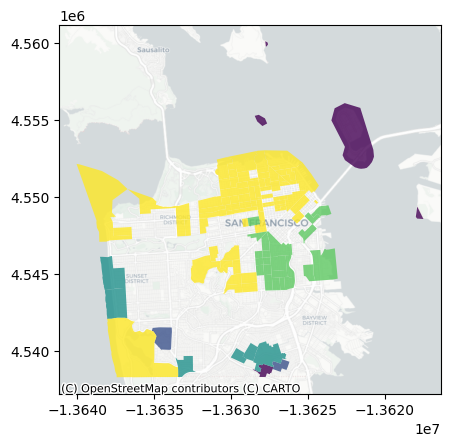

In [239]:
test = suburb_proportions_gdf.merge(suburb_scores_df[['geoid', 'gentrification_prediction_code']], on='geoid')
filtered = test[test[[0, 1, 2, 3, 4]].gt(60).any(axis=1)]

fig,ax=plt.subplots()
filtered = filtered.to_crs(epsg=3857)
filtered.plot("gentrification_prediction_code", alpha=0.8, ax=ax)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=suburb_proportions_gdf.crs)

### Plot the proportion of listings in each of the classes

/tmp/ipykernel_15960/2396660761.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


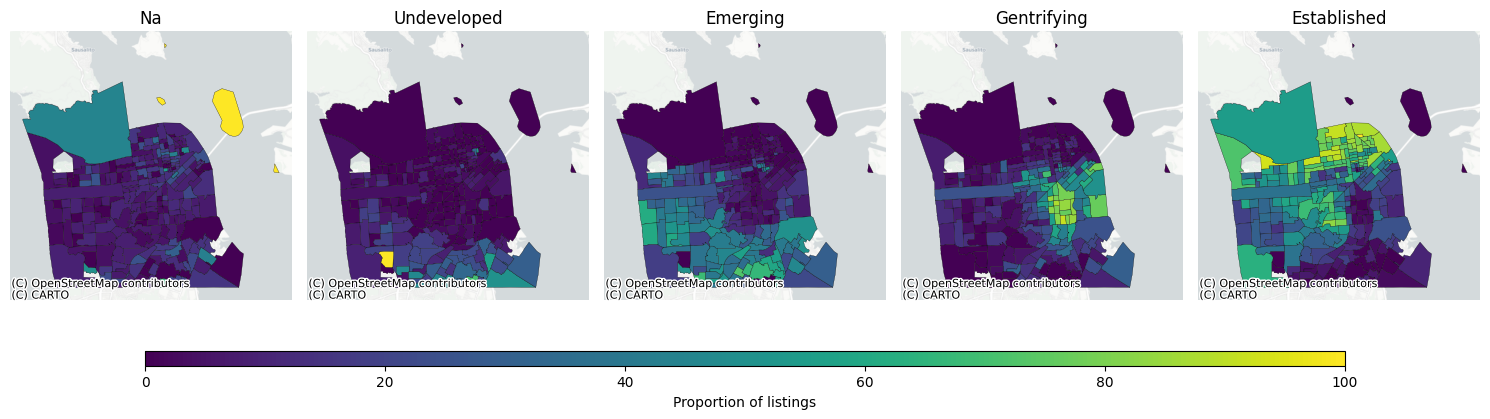

In [183]:
# Reproject your data to Web Mercator
suburb_proportions_gdf = suburb_proportions_gdf.to_crs(epsg=3857)

fig, axs = plt.subplots(ncols=5, figsize=(15, 5), sharex=True, sharey=True)

norm = colors.Normalize(vmin=0, vmax=100)  # or 100 if your values are percentages
cmap = cm.viridis

for key, item in mapping.items():
    ax = axs[item]
    suburb_proportions_gdf.plot(column=item,ax=ax,cmap=cmap,norm=norm,legend=False,linewidth=0.2,edgecolor='black')
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=suburb_proportions_gdf.crs)
    ax.set_title(key)
    ax.axis('off')  # optional: remove axis ticks

# Shared colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.03])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Proportion of listings')

plt.tight_layout()


### Calculate entropy for each neighbourhood

In [273]:
# entropy_scores = proportions.apply(entropy, axis=1)
# entropy_scores_df=pd.DataFrame({'geoid':proportions['geoid'], "entropy_scores":entropy_scores})
# entropy_scores_with_geom = census_tracts[['geoid', 'geometry']].merge(entropy_scores_df, on='geoid')
# entropy_scores_with_geom.plot('entropy_scores', legend=True);

### Calculate Kendall's W

Kendall’s W measures the degree of agreement among raters who assign ranks to a set of items. It ranges from 0 (no agreement) to 1 (complete agreement).

In [268]:
# Step 2: Group all scores by neighbourhood (Keep only those with more than 5 scores
grouped_scores = (
    listings_with_geoid
    .groupby('geoid')
    .filter(lambda x: len(x) >= 5)
    .groupby('geoid')['gentrification_prediction_code']
    .apply(list))

# Step 4: Define function to compute Kendall’s W (adapted for single-item ratings)
def kendalls_w(scores):
    m = len(scores)
    if m <= 1:
        return np.nan  # Cannot compute agreement with fewer than 2 raters

    R_bar = np.mean(scores)
    S = sum((r - R_bar) ** 2 for r in scores)
    n = len(mapping)  # Number of possible categories
    W = 12 * S / (m**2 * (n**2 - 1))
    return W

# Step 5: Apply function to each neighbourhood
kendall_w_per_geo = grouped_scores.apply(kendalls_w).rename("kendalls_w")
# # Optional: Join back to your polygon GeoDataFrame
kendall_gdf = census_tracts[['geoid', 'geometry']].merge(kendall_w_per_geo, on='geoid')

<Axes: >

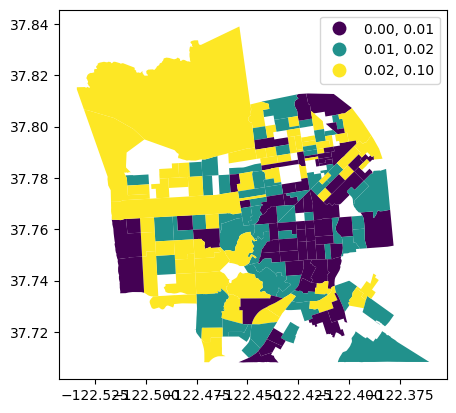

In [267]:
import mapclassify
kendall_gdf.plot("kendalls_w", cmap="viridis", scheme="quantiles", k=3, legend=True)

### Compare to the index

In [ ]:
gdf_gentrification_idx_bay = gdf_gentrification_idx_bay[gdf_gentrification_idx_bay['gentrification_prediction_code'].notna()] 

### Drop the NA scores for the LLM cats

In [ ]:
# scores_and_index = scores_and_index[scores_and_index['gentrification_prediction_code']!=0]

In [ ]:
crosstab = pd.crosstab(gdf_gentrification_idx_bay['gentrification_prediction_code'], gdf_gentrification_idx_bay['Typology_code'])

plt.figure(figsize=(8, 6))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues')
plt.title('Cross-tabulation Heatmap: Displacement index vs LLM Code')
plt.xlabel('Displacement index code')
plt.ylabel('LLM code')
plt.show()

### Normalised to show the percentage of values in that row in each column

In [ ]:
crosstab = pd.crosstab(gdf_gentrification_idx_bay['gentrification_prediction_code'], gdf_gentrification_idx_bay['Typology_code'])
normalized = crosstab.div(crosstab.sum(axis=1), axis=0).round(2)
plt.figure(figsize=(8, 6))
sns.heatmap(normalized, annot=True, fmt='.2f', cmap='Blues', cbar=True)
plt.title('Normalized Confusion Matrix (row-wise)', fontsize=14)
plt.xlabel('Index Code')
plt.ylabel('LLM Code')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

# Cross-tabulation
crosstab = pd.crosstab(gdf_gentrification_idx_bay['gentrification_prediction_code'], gdf_gentrification_idx_bay['Typology_code'])

# Optional: ensure square structure
all_classes = sorted(set(gdf_gentrification_idx_bay['gentrification_prediction_code']) |
                     set(gdf_gentrification_idx_bay['Typology_code']))
crosstab = crosstab.reindex(index=all_classes, columns=all_classes, fill_value=0)

In [ ]:
# chi2, p, dof, expected = chi2_contingency(crosstab) 
# # Pearson residuals = (observed - expected) / sqrt(expected)
# residuals = (crosstab - expected) / (expected ** 0.5)

In [ ]:
# Convert to dict with tuple keys: (LLM, Index)
mosaic_data = {
    (str(int(i)), str(int(j))): crosstab.loc[i, j]
    for i in crosstab.index
    for j in crosstab.columns}

# Color mapping based on residuals
def props(key):
    i, j = int(key[0]), int(key[1])
    r = residuals.loc[i, j]
    # blue for positive residuals, red for negative, white ~ no deviation
    if r > 1.96:
        return {'color': '#2166ac'}  # strong positive
    elif r < -1.96:
        return {'color': '#b2182b'}  # strong negative
    else:
        return {'color': '#f7f7f7'}  # not significant

In [ ]:
# Suppose these are all possible categories (adjust as needed)
all_predictions = gdf_gentrification_idx_bay['gentrification_prediction_code'].unique()
all_classifications = all_classifications = np.arange(1, 9) 

# Create full cartesian product of all pairs
full_index = pd.MultiIndex.from_product(
    [all_predictions, all_classifications],
    names=['gentrification_prediction_code', 'Typology_code'])

# Group and count as you did
mosaic_df = (
    gdf_gentrification_idx_bay
    .groupby(['gentrification_prediction_code', 'Typology_code'])
    .size()
    .reindex(full_index, fill_value=0)  # fill missing pairs with 0 count
    .reset_index(name='count'))

# Rename columns
mosaic_df.columns = ['gentrification_prediction_code', 'Typology_code', 'count']
mosaic_df = mosaic_df.sort_values((['gentrification_prediction_code', 'Typology_code']))

# Then pivot, etc.
table = mosaic_df.pivot_table(index='gentrification_prediction_code', columns='Typology_code', values='count', aggfunc='sum', fill_value=0)

In [ ]:
import matplotlib.patches as mpatches
from statsmodels.graphics.mosaicplot import mosaic

# Define a color for each classification column
classification_colors = {
    '1': '#d73027',
    '2': '#fc8d59',
    '3': '#fee08b',
    '4': '#d9ef8b',
    '5': '#91cf60',
    '6': '#1a9850',
    '7': '#4575b4',
    '8': '#313695'
}
def props(key):
    classification = str(key[1])  # column key
    color = classification_colors.get(classification, '#f0f0f0')  # fallback color
    return {'color': color}


In [ ]:
mosaic_data = {
    (str(row), str(col)): table.loc[row, col]
    for row in table.index
    for col in table.columns}

# Total for percent labels
total = sum(mosaic_data.values())

# Label function
def labelizer(key):
    pct = mosaic_data[key] / total * 100
    return f"{pct:.1f}%"

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
mosaic(
    mosaic_data,
    labelizer=labelizer,
    gap=0.02, axes_label=False, properties=props, ax=ax)

legend_patches = [
    mpatches.Patch(color=color, label=f'GI {cls}')
    for cls, color in classification_colors.items()]

plt.legend(
    handles=legend_patches,
    title='Classification',
    bbox_to_anchor=(1.05, 1),
    loc='upper left')

# Extract x/y categories from data
x_labels = mosaic_df['gentrification_prediction_code'].unique()
x_labels = ['NA', 'Undeveloped', 'Emerging', 'Gentrifying', 'Established']
y_labels = mosaic_df['Typology_code'].unique()

# Set axis ticks manually (adjust positions if necessary)
# ax.set_xticks([i / len(x_labels) + 0.5 / len(x_labels) for i in range(len(x_labels))])
ax.set_xticks([0.03,0.13,0.25,0.41,0.77])
ax.set_xticklabels(x_labels, rotation=0)
# ax.set_yticks([i / len(y_labels) + 0.5 / len(y_labels) for i in range(len(y_labels))])
# ax.set_yticklabels(y_labels)

# Add axis titles
# ax.set_xlabel('Classification from LLM')
ax.set_ylabel('Gentrification Index')

plt.tight_layout()
plt.show()
